# Le Data Mining pour la prévision de succès des films

#### Ce projet a été réalisé par Lilia Ennouri, Kais Ben Daamech et Yessine Borchani

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer ,StandardScaler , LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import naive_bayes
import operator
import random
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier  
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA

%matplotlib inline

# Données 
Pour les données utilisées, nous avons choisi le <strong> 5000 imdb movies dataset </strong> de <strong>Kaggle</strong><br/>
Ce jeu de données possède initialement 5044 lignes et 28 attributs. Nous présenterons et nous analyserons les différents attributs des données lors de la première partie du projet.

# I) Première approche

Pour la première approche, nous allons sélectionner manuellement tous les attributs à utiliser selon leur corrélation avec le label et leur indépendance. Nous allons travailler sur un nombre limité d'attributs

In [42]:
mov=pd.read_csv("movie_metadata.csv")

# 1) Analyse et data cleaning

* On affiche le nombre de NAN pour chaque feature

In [43]:
mov.isnull().sum() 

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

* On supprime les lignes contenant des valeurs NAN

In [44]:
mov = mov.dropna()
#mov

* On affiche la distribution des scores IMDB

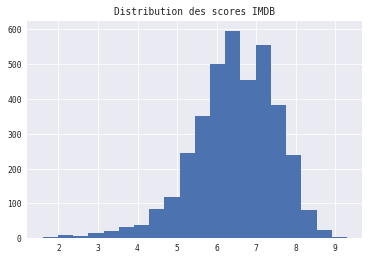

In [45]:
font = {'fontname':'Arial', 'size':'14'}
title_font = { 'weight' : 'bold','size':'16'}
plt.hist(mov.imdb_score, bins=20)
plt.title("Distribution des scores IMDB")
plt.show()

* On affiche les noms des différentes colonnes du dataframe

In [46]:
mov.columns.values

array(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_2_name', 'actor_1_facebook_likes', 'gross', 'genres',
       'actor_1_name', 'movie_title', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'aspect_ratio', 'movie_facebook_likes'], dtype=object)

* On définit une fonction qui permet de visualiser la variation des différents features par rapport au score IMDB

In [47]:
def scatter_plot(x,y,x_label,y_label):
    plt.scatter(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

* On affiche la variation de Aspect Ratio par rapport au score IMDB

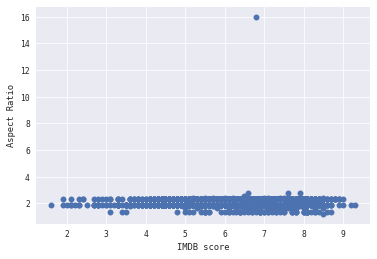

In [48]:
scatter_plot(mov.imdb_score, mov.aspect_ratio, "IMDB score", "Aspect Ratio")

* L'attribut aspect_ratio ne semble pas important pour la prédiction du succès des films. On ne va donc pas le considérer.

* Les attributs movie_imdb_link et movie_title sont uniques pour chaque film. Ils ne sont donc pas importants pour la prédiction de son succès. On ne va également pas le considérer.

In [49]:
mov.drop(["aspect_ratio", "movie_imdb_link", "movie_title"], inplace=True, axis=1)

* On va séparer les features en numeric_features, string_features et categorical_features

In [50]:
numeric_features=mov._get_numeric_data().columns.values.tolist()

text_features=mov.columns.values.tolist()
text_features=[i for i in text_features if i not in numeric_features]



string_features=["plot_keywords", "genres"]

categorical_features=[i for i in text_features if i not in string_features]

numeric_features.remove("title_year") 
categorical_features.append("title_year")

numeric_features.remove("imdb_score") 


* On affiche le nombre de zéros pour chaque feature

In [51]:
count = pd.DataFrame({'zero count':[0]*len(numeric_features)},index = numeric_features)
for element in numeric_features:
    count.loc[element,'zero count'] = sum(np.array(mov[element])==0)
print(count)

                           zero count
num_critic_for_reviews              0
duration                            0
director_facebook_likes           642
actor_3_facebook_likes             27
actor_1_facebook_likes              1
gross                               0
num_voted_users                     0
cast_total_facebook_likes           1
facenumber_in_poster             1582
num_user_for_reviews                0
budget                              0
actor_2_facebook_likes             11
movie_facebook_likes             1742


* On remarque que les attributs: director_facebook_likes et movie_facebook_likes sont nuls pour plusieurs lignes. On ne va donc pas les considérer

* L'attribut facenumber_in_poster a lui aussi plusieurs valeurs nulles ce qui est très normal car beaucoup d'affiches de films ne contiennent aucun visage. On ne va donc pas le supprimer

In [52]:
mov.drop(["director_facebook_likes", "movie_facebook_likes"], inplace=True, axis=1)
if "director_facebook_likes" in numeric_features: numeric_features.remove("director_facebook_likes")
if "movie_facebook_likes" in numeric_features: numeric_features.remove("movie_facebook_likes")

### a) Data cleaning pour les valeurs numériques

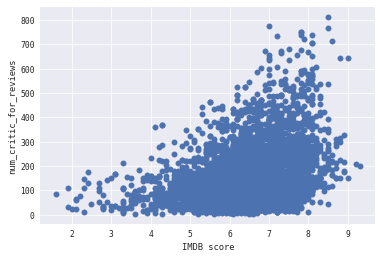

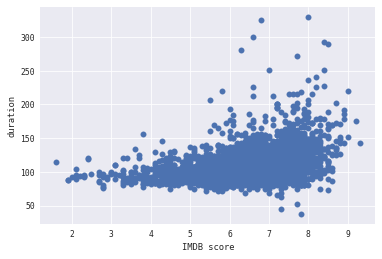

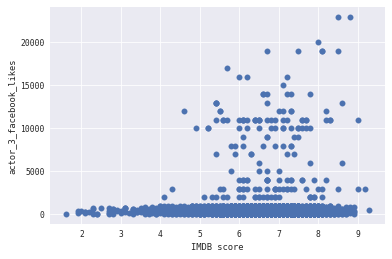

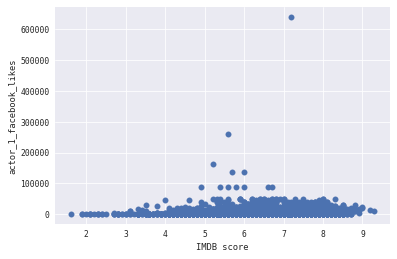

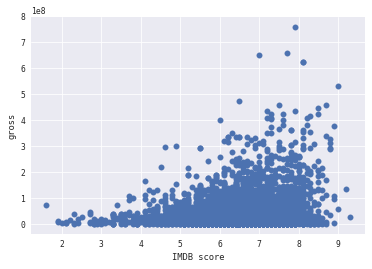

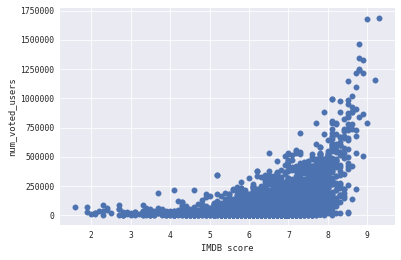

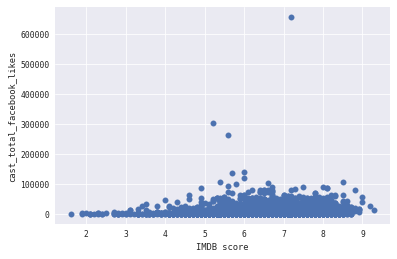

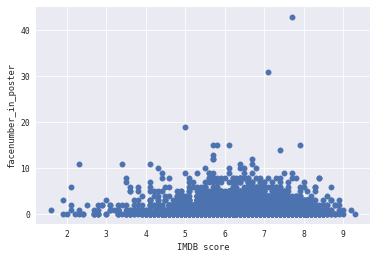

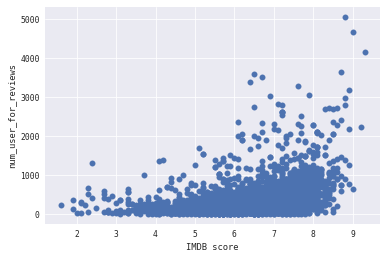

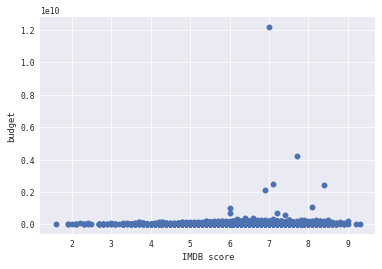

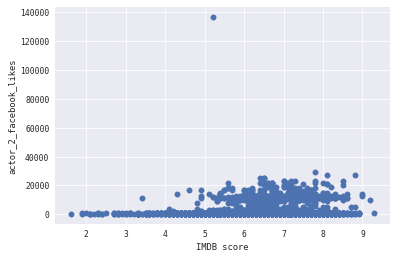

In [53]:
for num in numeric_features:
    scatter_plot(mov["imdb_score"], mov[num], "IMDB score", str(num))

* On remarque que le budget n'influence pas le succès du film, on ne va donc pas le considérer.

In [54]:
mov.drop(["budget"], inplace=True, axis=1)
if "budget" in numeric_features: numeric_features.remove("budget")

* Dans la figure qui montre la variation de actor_1_facebook_likes et le score IMDB, on a une valeur aberrante. On va donc la supprimer

In [55]:
mov.drop(mov[mov["actor_1_facebook_likes"]==mov["actor_1_facebook_likes"].max()].index , inplace=True, axis=0)

* On donne un nom à la ligne de label

In [56]:
label = mov["imdb_score"]
mov.drop(["imdb_score"], inplace=True, axis=1)

* On va standardiser les valeurs numériques pour obtenir une moyenne nulle et un écart type égal à 1

In [57]:
scl=StandardScaler()

mov[numeric_features]=scl.fit_transform(mov[numeric_features])

mov[numeric_features]=scl.fit_transform(mov[numeric_features])

#mov[numeric_features]


* On calcule la corrélation de chaque numeric feature avev le label

In [58]:
correl={}
sorted_cor = []
for f in numeric_features:
    correl[f]=pearsonr(mov[f], label)
sorted_cor = sorted(correl.items(), key=operator.itemgetter(1), reverse=True)
print (sorted_cor)

[('num_voted_users', (0.48233616412253616, 4.1997876425901784e-218)), ('duration', (0.3663592171558281, 1.2479798965075366e-119)), ('num_critic_for_reviews', (0.3478881776326269, 2.775195889262611e-107)), ('num_user_for_reviews', (0.3249300811038967, 4.677231901912372e-93)), ('gross', (0.21467622491820826, 2.1366513169073537e-40)), ('cast_total_facebook_likes', (0.12046996059904169, 1.2948517249862287e-13)), ('actor_1_facebook_likes', (0.1152122023951581, 1.4289082498731154e-12)), ('actor_2_facebook_likes', (0.10215843662788006, 3.509693487883336e-10)), ('actor_3_facebook_likes', (0.06503223079364075, 6.66485114552749e-05)), ('facenumber_in_poster', (-0.0658532844801531, 5.381666512726809e-05))]


* On affiche la heatmap des valeurs numériques

In [59]:
def corrmap(features, title):
    sns.set(context="paper", font="monospace")
    corrmat = mov[features].corr()
    f, ax = plt.subplots(figsize=(12, 9))
    plt.title(title, **title_font)
# Draw the heatmap using seaborn
    sns.heatmap(corrmat, vmax=.8, square=True,cmap="Blues")
    

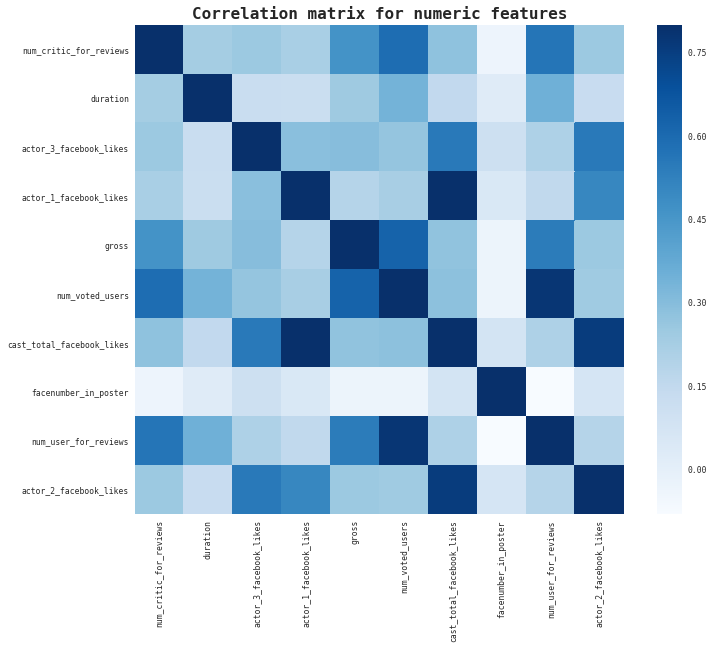

In [60]:
corrmap(numeric_features,"Correlation matrix for numeric features")

* On remarque que cast_total_facebook_likes est corrélé avec actor_1_facebook_likes, actor_2_facebook_likes et actor_3_facebook_likes puisque la première est la somme des trois autres. On va donc les remplacer par ces deux catégories: actor_1_facebook_likes and other_actors_facebook_likes.

* Il y a aussi une forte corrélation entre num_voted_users, num_user_for_reviews et num_critic_for_reviews. On va donc faire leur moyenne dans une variable appelée movie_success.

In [61]:
mov["movie_success"]=(mov['num_critic_for_reviews']+mov["num_voted_users"]
                +mov["num_user_for_reviews"])/3
mov["other_actors_facebook_likes"]=mov["actor_2_facebook_likes"]+mov["actor_3_facebook_likes"]
mov.drop(["cast_total_facebook_likes",'num_critic_for_reviews',"num_voted_users","num_user_for_reviews","actor_2_facebook_likes",
"actor_3_facebook_likes"], inplace=True, axis=1)

if "cast_total_facebook_likes" in numeric_features: numeric_features.remove("cast_total_facebook_likes")
if "num_critic_for_reviews" in numeric_features: numeric_features.remove("num_critic_for_reviews")
if "num_voted_users" in numeric_features: numeric_features.remove("num_voted_users")
if "num_user_for_reviews" in numeric_features: numeric_features.remove("num_user_for_reviews")
if "actor_2_facebook_likes" in numeric_features: numeric_features.remove("actor_2_facebook_likes")
if "actor_3_facebook_likes" in numeric_features: numeric_features.remove("actor_3_facebook_likes")
numeric_features.extend(["movie_success", "other_actors_facebook_likes"])

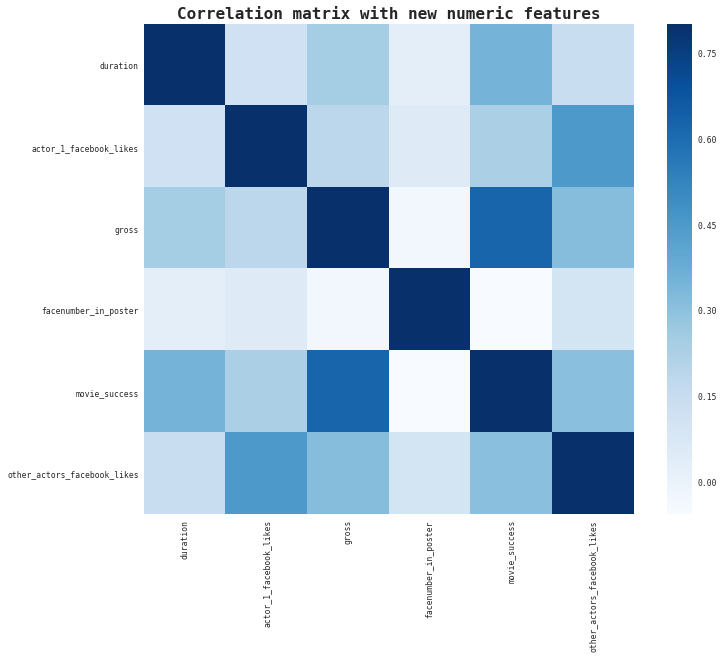

In [62]:
corrmap(numeric_features, "Correlation matrix with new numeric features")

* On recalcule la corrélation entre les features et le label

In [63]:
correl={}
sorted_cor = []
for f in numeric_features:
    correl[f]=pearsonr(mov[f], label)
sorted_cor = sorted(correl.items(), key=operator.itemgetter(1), reverse=True)
print (sorted_cor)

[('movie_success', (0.4407128376096391, 3.002100245930705e-178)), ('duration', (0.3663592171558281, 1.2479798965075366e-119)), ('gross', (0.21467622491820826, 2.1366513169073537e-40)), ('actor_1_facebook_likes', (0.1152122023951581, 1.4289082498731154e-12)), ('other_actors_facebook_likes', (0.09485002828534914, 5.765452943290699e-09)), ('facenumber_in_poster', (-0.0658532844801531, 5.381666512726809e-05))]


* On choisit les attributs les plus corrélés avec le label

In [64]:
predictors = ["movie_success","duration","gross","other_actors_facebook_likes","actor_1_facebook_likes"]

### b) Data cleaning pour les valeurs catégoriques

* On afffiche les attributs catégoriques

In [65]:
categorical_features

['color',
 'director_name',
 'actor_2_name',
 'actor_1_name',
 'actor_3_name',
 'language',
 'country',
 'content_rating',
 'title_year']

* On ne doit pas manipuler de données textuelles, on va donc les convertir en données numériques en utilisant get_dummies de pandas

In [66]:
for feat in categorical_features:
    mov=pd.concat([mov, pd.get_dummies(mov[feat], prefix=feat, dummy_na=True)],axis=1)
print(mov.columns.values)

['color' 'director_name' 'duration' ... 'title_year_2015.0'
 'title_year_2016.0' 'title_year_nan']


* On élimine les anciennes valeurs (valeurs textuelles) pour ne laisser que les nouvelles valeurs (valeurs numériques)

In [67]:
cat_dummies=[]
cat_dummies=[i for i in mov.columns.values.tolist() if i not in numeric_features]
cat_dummies=[i for i in cat_dummies if i not in text_features]
cat_dummies.remove("title_year")
cat_dummies[:10]

['color_ Black and White',
 'color_Color',
 'color_nan',
 'director_name_Aaron Schneider',
 'director_name_Aaron Seltzer',
 'director_name_Abel Ferrara',
 'director_name_Adam Goldberg',
 'director_name_Adam Marcus',
 'director_name_Adam McKay',
 'director_name_Adam Rapp']

* On calcule la corrélation des nouveaux attributs avec le label

In [68]:
correl={}
sorted_cor = []
for f in cat_dummies:
    correl[f]=pearsonr(mov[f], label)
sorted_cor = sorted(correl.items(), key=operator.itemgetter(1), reverse=True)

print (sorted_cor[0:3])
print("")
print (sorted_cor[-3:])

E:\Programs\Anaconda3\lib\site-packages\scipy\stats\stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
E:\Programs\Anaconda3\lib\site-packages\scipy\stats\stats.py:5240: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


[('color_ Black and White', (0.11772184688036143, 4.602811824726709e-13)), ('color_nan', (nan, 1.0)), ('director_name_Christopher Nolan', (0.08574378340076784, 1.4237604210286728e-07))]

[('country_USA', (-0.14330136441473784, 1.1055989500220425e-18)), ('language_English', (-0.17283583651288104, 1.4385077898460258e-26)), ('title_year_nan', (nan, 1.0))]


* On sélectionne les attributs les plus corrélés avec le label.

In [69]:
predictors1 = []
for f in sorted_cor:
    if abs(f[1][0])>0.07:
        predictors1.append(f[0])
#predictors1

* On visualise la corrélation des attributs entre eux

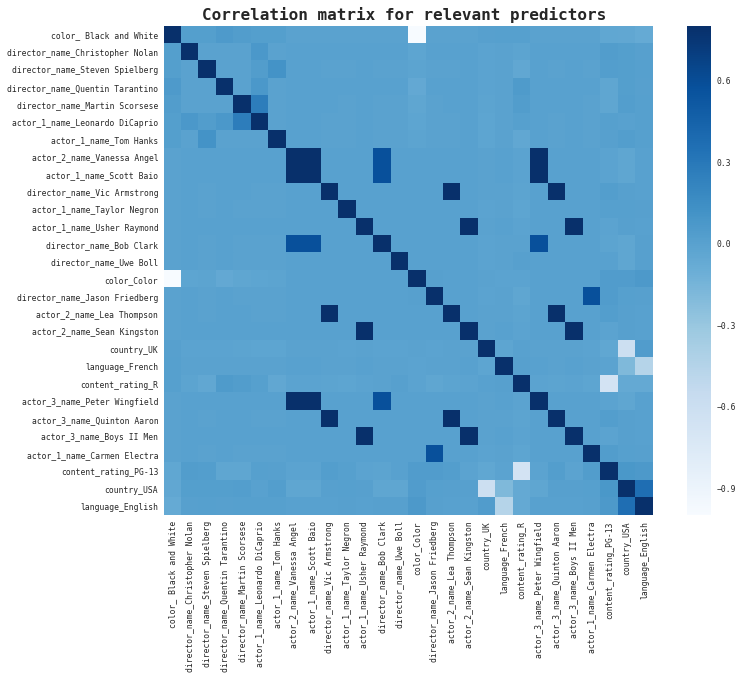

In [70]:
corrmap(predictors1, "Correlation matrix for relevant predictors ")

* On ne laisse que les attributs faiblement corrélés entre eux

In [71]:
predictors1 = ['color_ Black and White',
 'director_name_Christopher Nolan',
 'director_name_Steven Spielberg',
 'director_name_Quentin Tarantino',
 'director_name_Martin Scorsese',
 'actor_1_name_Leonardo DiCaprio',
 'actor_1_name_Tom Hanks',
 'actor_1_name_Taylor Negron',
 'director_name_Uwe Boll',
 'actor_3_name_Peter Wingfield',
 'actor_3_name_Quinton Aaron',
 'actor_3_name_Boys II Men',
 'actor_1_name_Carmen Electra',
 'content_rating_PG-13',
 'country_USA',
 'language_English']

* On vérifie que les attributs choisis sont faiblement corrélés

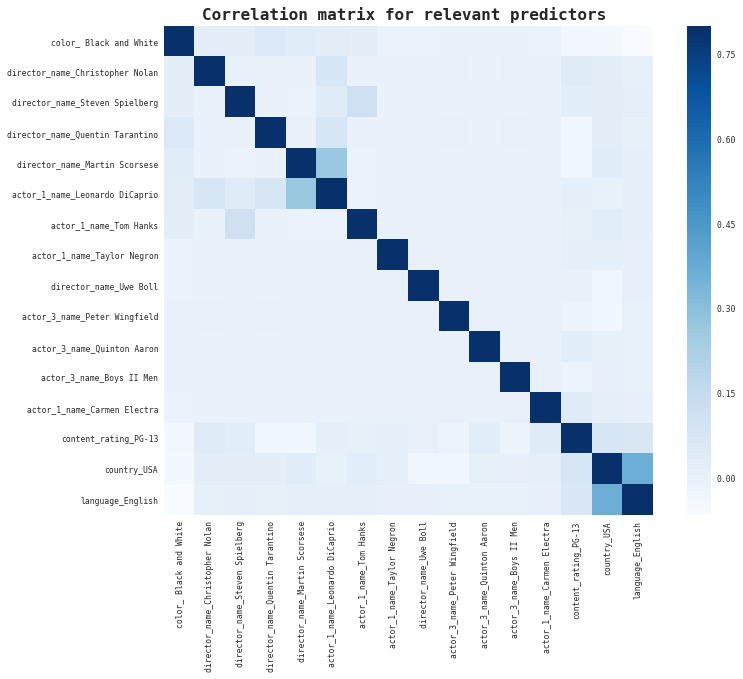

In [72]:
corrmap(predictors1, "Correlation matrix for relevant predictors ")

### c) Data cleaning pour les chaines de caractère

#### Plot keywords

* L'attribut plot_keywords contient les différents mots clés du plot du film, séparés par |. On doit donc les séparer et les numériser

In [73]:
mov["plot_keywords"]=mov["plot_keywords"].fillna("None")

def token(text):
    return(text.split("|"))

cv=CountVectorizer(max_features=200,tokenizer=token )
plot_keywords_words=cv.fit_transform(mov["plot_keywords"])

plot_keywords_words=plot_keywords_words.toarray()

words = cv.get_feature_names()

words=["Keyword_"+w for w in words]

keywords=pd.DataFrame(plot_keywords_words, columns=words)

* On ne sélectionne que les mots clés qui apparaissent plus de 80 fois

In [74]:
keys=[w for w in words if keywords[w].sum()>80] 
print (len(keys))
keys

5


['Keyword_death',
 'Keyword_friend',
 'Keyword_love',
 'Keyword_murder',
 'Keyword_police']

* On réinitialise l'index de notre dataframe pour pouvoir le concaténer avec keywords[keys]

In [75]:
mov.reset_index(inplace=True)

In [76]:
mov=pd.concat([mov, keywords[keys]],axis=1)

#### Genres

* L'attribut genres contient les différents genres du plot du film, séparés par |. On doit donc les séparer et les numériser

In [77]:
mov["genres"]=mov["genres"].fillna("None")

def token(text):
    return(text.split("|"))

cv=CountVectorizer(max_features=200,tokenizer=token )
gen=cv.fit_transform(mov["genres"])

gen=gen.toarray()

genre = cv.get_feature_names()
genre =["genre_"+g for g in genre]

genre_df=pd.DataFrame(gen, columns=genre)

* On ne sélectionne que les genres qui apparaissent plus de 80 fois

In [78]:
best_genres=[g for g in genre if genre_df[g].sum()>80] 
### takes the keywords that concern at least 60 (totally arbitrary) of the movies
print (len(best_genres))
best_genres[:5]

19


['genre_action',
 'genre_adventure',
 'genre_animation',
 'genre_biography',
 'genre_comedy']

* On concatène le dataframe avec le dataframe des genres

In [79]:
mov=pd.concat([mov, genre_df[best_genres]],axis=1)

* On calcule la corrélation des genres obtenus avec le label

In [80]:
correl={}
sorted_cor = []
for f in best_genres:
    correl[f]=pearsonr(mov[f], label)
sorted_cor = sorted(correl.items(), key=operator.itemgetter(1), reverse=True)

print (sorted_cor[:5])

[('genre_drama', (0.3093896388227752, 4.2054656703936335e-84)), ('genre_biography', (0.17098321865122226, 4.982155742701569e-26)), ('genre_history', (0.1327879327767188, 3.0716060848938544e-16)), ('genre_war', (0.11502743393359145, 1.551709403433872e-12)), ('genre_animation', (0.05276248982617175, 0.0012191602431430746))]


* On choisit les genres les plus importants

In [81]:
the_genres = []
for f in sorted_cor:
    if abs(f[1][0])>0.06:
        the_genres.append(f[0])
the_genres

['genre_drama',
 'genre_biography',
 'genre_history',
 'genre_war',
 'genre_fantasy',
 'genre_family',
 'genre_action',
 'genre_horror',
 'genre_comedy']

* On visualise la corrélation entre les genres sélectionnés

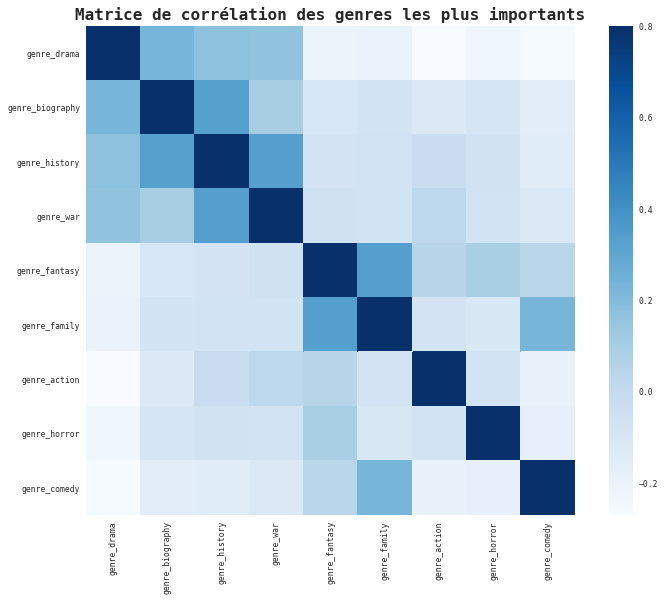

In [82]:
corrmap(the_genres, "Matrice de corrélation des genres les plus importants")

Les genres sont faiblement corrélés entre eux

* On visualise la corrélation entre les predictors choisis

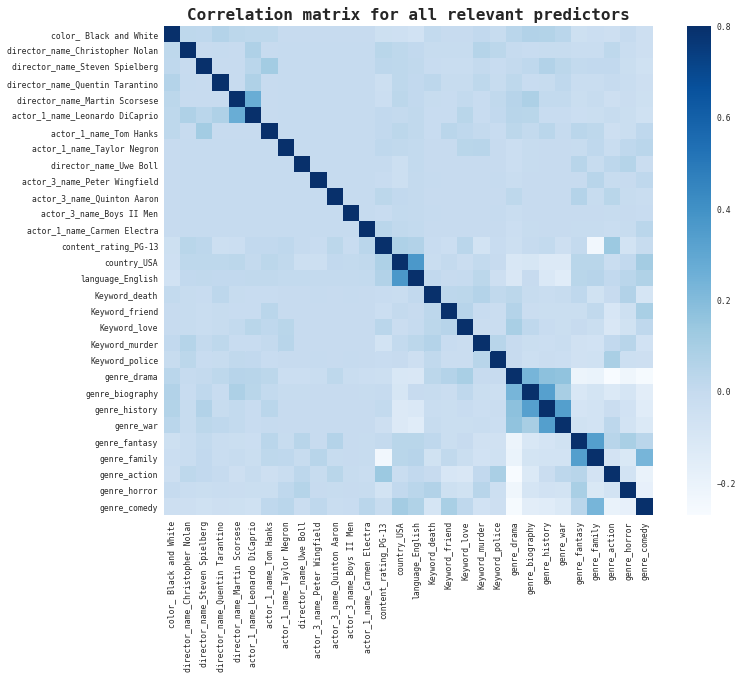

In [83]:
corrmap(predictors1+keys+the_genres, "Correlation matrix for all relevant predictors")

* On construit notre ensemble de predictors

In [84]:
for el in (predictors1+the_genres):
    predictors.append(el)

# 2) Traitement

* On réinitialise les index de label pour qu'ils aient les mêmes indexes que le dataframe

In [49]:
label.reset_index(drop=True,inplace=True)

* On divise les données en train et test

In [50]:
mov = mov[predictors]

## 2.1) Regression

### 2.1.1) Linear Regression

In [51]:
x_train, x_test, y_train, y_test = train_test_split(mov, label,test_size=0.25, random_state=0)

#### Sans PCA

In [53]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [54]:
pred_model_lr = model_lr.predict(x_test)

In [55]:
model_lr.score(x_test, y_test)

0.44092425374833488

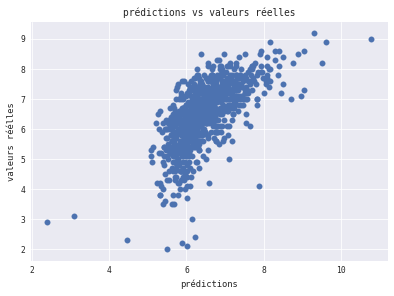

In [56]:
y_test_fitted = model_lr.predict(x_test)
plt.scatter(y_test_fitted, y_test)
plt.title("prédictions vs valeurs réelles")
plt.xlabel("prédictions")
plt.ylabel("valeurs réélles")
plt.show()

On remarque que même si le score n'est pas très haut, et donc les prédictions des scores IMDB ne sont pas souvent égales aux scores IMDB rééls, les prédictions sont proches des valeurs réélles.

#### Avec PCA

In [57]:
pca = PCA(n_components=10)
pca.fit(x_train)
x_train_transformed = pca.transform(x_train)

x_test_transformed = pca.transform(x_test)

In [58]:
model_lr = LinearRegression()
model_lr.fit(x_train_transformed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [59]:
pred_model_lr = model_lr.predict(x_test_transformed)

In [60]:
model_lr.score(x_test_transformed, y_test)

0.38656688285132867

On remarque que le score sans PCA est meilleur que celui avec PCA

### 2.1.2) Random Forest Regressor

#### Sans PCA

In [61]:
model_dtr = RandomForestRegressor()
model_dtr.fit(x_train, y_train)

C:\Users\WIN8\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [62]:
pred_model_dtr = model_dtr.predict(x_test)

In [63]:
model_dtr.score(x_test, y_test)

0.40514391689555951

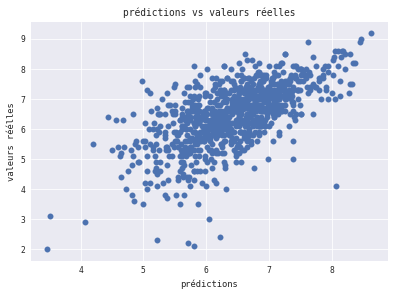

In [64]:
y_test_fitted = model_dtr.predict(x_test)
plt.scatter(y_test_fitted, y_test)
plt.title("prédictions vs valeurs réelles")
plt.xlabel("prédictions")
plt.ylabel("valeurs réélles")
plt.show()

En utilisant le Random Forest Regressor, on remarque aussi que les prédictions sont proches des valeurs réélles.

#### Avec PCA

In [65]:
model_dtr = RandomForestRegressor()
model_dtr.fit(x_train_transformed, y_train)

C:\Users\WIN8\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [66]:
pred_model_dtr = model_dtr.predict(x_test_transformed)

In [67]:
model_dtr.score(x_test_transformed, y_test)

0.37615321648032252

Pour le modère Random Forest Regressor aussi, le score sans PCA est meilleur que celui avec PCA

## 2.2) Classification

Maintenant, au lieu de prédire la valeur exacte de l'IMDB, on va classifier les films en 3 catégories: 
    - Mauvais (1) : IMDB < 3.4
    - Moyen (2) : 3.4 <= IMDB <= 6.7
    - Bon (3) : 6.7 < IMDB

In [68]:
for i in range(len(label)):
    if (label[i]<3.4): 
        label[i] = int(1)
    elif (label[i] <= 6.7):
        label[i] = int(2)
    else:
        label[i] = int(3)

C:\Users\WIN8\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\WIN8\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\WIN8\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [70]:
x_train, x_test, y_train, y_test = train_test_split(mov, label,test_size=0.25, random_state=0)

### 2.2.1) Decision tree

In [71]:
model_dt = DecisionTreeClassifier(criterion='entropy' , max_depth = 10)
model_dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [72]:
pred_model_dt = model_dt.predict(x_test)

In [73]:
model_dt.score(x_test, y_test)

0.68690095846645371

In [74]:
pred_model_dt = model_dt.predict(x_test)

### 2.2.2) K-Nearest Neighbors

In [75]:
model_knn = KNeighborsClassifier(n_neighbors=5)  
model_knn.fit(x_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [76]:
pred_model_knn = model_knn.predict(x_test)

In [77]:
model_knn.score(x_test, y_test)

0.73482428115015974

* On veut trouver la valeur de K optimale

In [78]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):  
    model_knn = KNeighborsClassifier(n_neighbors=i)
    model_knn.fit(x_train, y_train)
    pred_i = model_knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

Text(0,0.5,'Mean Error')

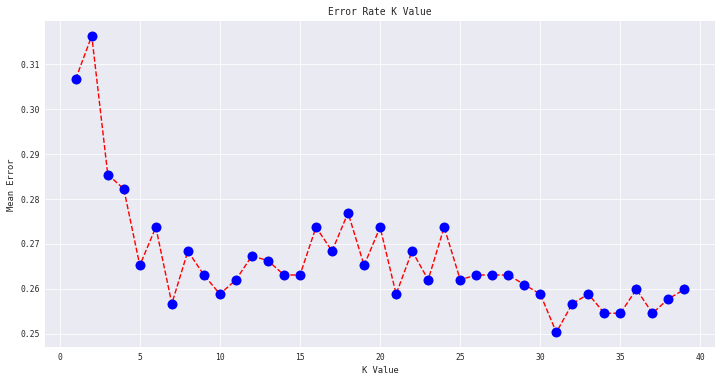

In [79]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

* On choisit la valeur qui donne un taux d'erreur minimal

In [80]:
model_knn = KNeighborsClassifier(n_neighbors=error.index(min(error))+1)  
model_knn.fit(x_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=31, p=2,
           weights='uniform')

In [81]:
pred_model_knn = model_knn.predict(x_test)

In [82]:
model_knn.score(x_test, y_test)

0.7497337593184239

### 2.2.3) Random Forest

In [83]:
model_rfc=RandomForestClassifier(n_estimators=50)
model_rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [84]:
pred_model_rfc = model_rfc.predict(x_test)

In [85]:
model_rfc.score(x_test, y_test)

0.76677316293929709

* Pour trouver les meilleurs hyper paramètres, nous allons utiliser un Grid

In [88]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [89]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.4min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [90]:
best_params = rf_random.best_params_
best_params

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 800}

In [91]:
model_rfc=RandomForestClassifier(bootstrap= True,
 max_depth= 40,
 max_features= 'sqrt',
 min_samples_leaf= 1,
 min_samples_split= 5,
 n_estimators= 800)
model_rfc.fit(x_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=40, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
rf_pred= rf_random.predict(x_test)

In [93]:
rf_random.score(x_test, y_test)

0.77635782747603832

### 2.2.4) SVM

In [94]:
model_svm = svm.SVC(gamma='scale', decision_function_shape='ovo')
model_svm.fit(x_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [95]:
pred_model_svm = model_svm.predict(x_test)

In [96]:
model_svm.score(x_test, y_test)

0.76464323748668794

# II) Deuxième approche

Dans cette partie, nous essayons d'abord d'entrainer les modèles sur l'ensemble de toutes les colonnes. <br/>
Nous allons essayer de mettre l'accent sur l'importance sur la partie data preprocessing, et donc montrer que non seulement les modèles prendront beaucoup plus de temps pour s'executer vu la taille des données, mais aussi, les résultats seront beaucoup pires que ceux des données minimisés. <br/>
Finalement, nous allons faire une <strong> Dimensionnality Reduction </strong> en utilisant <strong>ACP</strong>, et nous allons alors montrer que nous aurons les meilleurs résultats à partir de cette méthode.

In [85]:
mov=pd.read_csv("movie_metadata.csv")

# 1) Analyse et data cleaning

* On affiche le nombre de NAN pour chaque feature

In [86]:
mov.isnull().sum() 

color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

* On supprime les lignes contenant des valeurs nulles

In [87]:
mov = mov.dropna()


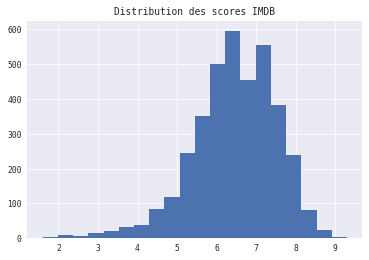

In [88]:
font = {'fontname':'Arial', 'size':'14'}
title_font = { 'weight' : 'bold','size':'16'}
plt.hist(mov.imdb_score, bins=20)
plt.title("Distribution des scores IMDB")
plt.show()

In [89]:
mov.columns.values

array(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_2_name', 'actor_1_facebook_likes', 'gross', 'genres',
       'actor_1_name', 'movie_title', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'actor_2_facebook_likes', 'imdb_score',
       'aspect_ratio', 'movie_facebook_likes'], dtype=object)

In [90]:
def scatter_plot(x,y,x_label,y_label):
    plt.scatter(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

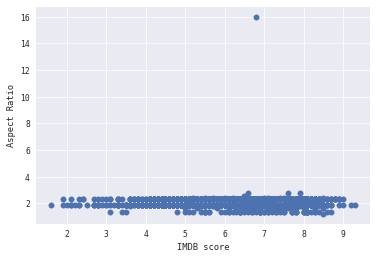

In [91]:
scatter_plot(mov.imdb_score, mov.aspect_ratio, "IMDB score", "Aspect Ratio")

* L'attribut aspect_ratio ne semble pas important pour la prédiction du succès des films. On ne va donc pas le considérer.
L'attribut movie_imdb_link est unique pour chaque film. Il n'est donc pas important pour la prédiction de son succès. On ne va également pas le considérer.

In [92]:
mov.drop(["aspect_ratio", "movie_imdb_link"], inplace=True, axis=1)

In [93]:
numeric_features=mov._get_numeric_data().columns.values.tolist()

text_features=mov.columns.values.tolist()
text_features=[i for i in text_features if i not in numeric_features]



string_features=["plot_keywords", "genres"]

categorical_features=[i for i in text_features if i not in string_features]

numeric_features.remove("title_year") 
categorical_features.append("title_year")

numeric_features.remove("imdb_score") 


In [94]:
count = pd.DataFrame({'zero count':[0]*len(numeric_features)},index = numeric_features)
for element in numeric_features:
    count.loc[element,'zero count'] = sum(np.array(mov[element])==0)
print(count)

                           zero count
num_critic_for_reviews              0
duration                            0
director_facebook_likes           642
actor_3_facebook_likes             27
actor_1_facebook_likes              1
gross                               0
num_voted_users                     0
cast_total_facebook_likes           1
facenumber_in_poster             1582
num_user_for_reviews                0
budget                              0
actor_2_facebook_likes             11
movie_facebook_likes             1742


* On remarque que les attributs: director_facebook_likes et movie_facebook_likes sont nuls pour plusieurs lignes. On ne va donc pas les considérer

In [95]:
mov.drop(["director_facebook_likes", "movie_facebook_likes"], inplace=True, axis=1)
if "director_facebook_likes" in numeric_features: numeric_features.remove("director_facebook_likes")
if "movie_facebook_likes" in numeric_features: numeric_features.remove("movie_facebook_likes")

### a) Data cleaning pour les valeurs numériques

In [96]:
mov.drop(mov[mov["actor_1_facebook_likes"]==mov["actor_1_facebook_likes"].max()].index , inplace=True, axis=0)

In [18]:
mov.drop(["budget"], inplace=True, axis=1)
if "budget" in numeric_features: numeric_features.remove("budget")

In [98]:
scl=StandardScaler()

mov[numeric_features]=scl.fit_transform(mov[numeric_features])

mov[numeric_features]=scl.fit_transform(mov[numeric_features])

#mov[numeric_features]


In [99]:
label = mov["imdb_score"]

In [100]:
mov.drop(["imdb_score"], inplace=True, axis=1)

* On remarque que cast_total_facebook_likes est corrélé avec actor_1_facebook_likes, actor_2_facebook_likes et actor_3_facebook_likes puisque la première est la somme des trois autres. On va donc les remplacer par ces deux catégories: actor_1_facebook_likes and other_actors_facebook_likes.

In [101]:
mov["other_actors_facebook_likes"]=mov["actor_2_facebook_likes"]+mov["actor_3_facebook_likes"]
mov.drop(["cast_total_facebook_likes","actor_2_facebook_likes",
"actor_3_facebook_likes"], inplace=True, axis=1)

if "cast_total_facebook_likes" in numeric_features: numeric_features.remove("cast_total_facebook_likes")
if "actor_2_facebook_likes" in numeric_features: numeric_features.remove("actor_2_facebook_likes")
if "actor_3_facebook_likes" in numeric_features: numeric_features.remove("actor_3_facebook_likes")
numeric_features.extend([ "other_actors_facebook_likes"])

### b) Data cleaning pour les valeurs catégoriques

In [103]:
for feat in categorical_features:
    mov=pd.concat([mov, pd.get_dummies(mov[feat], prefix=feat, dummy_na=True)],axis=1)
#print(mov.columns.values)

In [104]:
cat_dummies=[]
cat_dummies=[i for i in mov.columns.values.tolist() if i not in numeric_features]
cat_dummies=[i for i in cat_dummies if i not in text_features]
cat_dummies.remove("title_year")
#cat_dummies[:20]

### c) Data cleaning pour les chaines de caractère

#### Plot keywords

In [106]:
mov["plot_keywords"]=mov["plot_keywords"].fillna("None")

def token(text):
    return(text.split("|"))

cv=CountVectorizer(max_features=200,tokenizer=token )
plot_keywords_words=cv.fit_transform(mov["plot_keywords"])

plot_keywords_words=plot_keywords_words.toarray()

words = cv.get_feature_names()
words=["Keyword_"+w for w in words]

keywords=pd.DataFrame(plot_keywords_words, columns=words)

In [107]:
keys=[w for w in words if keywords[w].sum()>20] 
#print (len(keys))
#keys

In [108]:
mov.reset_index(inplace=True)

In [109]:
mov=pd.concat([mov, keywords[keys]],axis=1)

#### Genres

In [110]:
mov["genres"]=mov["genres"].fillna("None")

def token(text):
    return(text.split("|"))

cv=CountVectorizer(max_features=200,tokenizer=token )
gen=cv.fit_transform(mov["genres"])

gen=gen.toarray()

genre = cv.get_feature_names()
genre =["genre_"+g for g in genre]

genre_df=pd.DataFrame(gen, columns=genre)

In [111]:
best_genres=[g for g in genre if genre_df[g].sum()>20] 
### takes the keywords that concern at least 60 (totally arbitrary) of the movies
#print (len(best_genres))
#best_genres

In [112]:
mov=pd.concat([mov, genre_df[best_genres]],axis=1)

In [113]:
mov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Columns: 23541 entries, index to genre_western
dtypes: float64(10), int64(136), object(11), uint8(23384)
memory usage: 88.2+ MB


# 2) Traitement

In [114]:
label.reset_index(drop=True,inplace=True)

* On divise les données en train et test

In [115]:
mov = mov._get_numeric_data()

In [116]:
x_train, x_test, y_train, y_test = train_test_split(mov, label,test_size=0.25, random_state=0)

## 2.1) Regression

### 2.1.1) Linear Regression

In [117]:
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [118]:
pred_model_lr = model_lr.predict(x_test)

In [119]:
model_lr.score(x_test, y_test)

0.3737540642524071

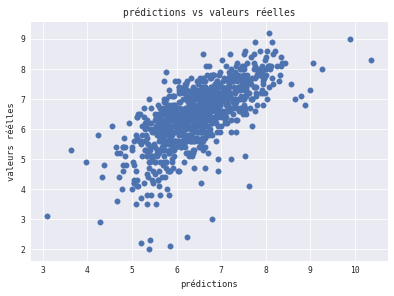

In [43]:
y_test_fitted = model_lr.predict(x_test)
plt.scatter(y_test_fitted, y_test)
plt.title("prédictions vs valeurs réelles")
plt.xlabel("prédictions")
plt.ylabel("valeurs réélles")
plt.show()

On remarque que même si le score n'est pas très haut, et donc les prédictions des scores IMDB ne sont pas souvent égales aux scores IMDB rééls, les prédictions sont proches des valeurs réélles.

### 2.1.2) Random Forest Regressor

In [44]:
model_dtr = RandomForestRegressor()
model_dtr.fit(x_train, y_train)

C:\Users\WIN8\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [45]:
pred_model_dtr = model_dtr.predict(x_test)

In [46]:
model_dtr.score(x_test, y_test)

0.58363467611319031

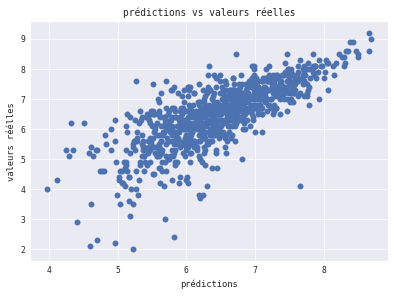

In [47]:
y_test_fitted = model_dtr.predict(x_test)
plt.scatter(y_test_fitted, y_test)
plt.title("prédictions vs valeurs réelles")
plt.xlabel("prédictions")
plt.ylabel("valeurs réélles")
plt.show()

## 2.2) Classification

Maintenant, au lieu de prédire la valeur exacte de l'IMDB, on va classifier les films en 3 catégories: 
    - Mauvais (1) : IMDB < 3.4
    - Moyen (2) : 3.4 <= IMDB <= 6.7
    - Bon (3) : 6.7 < IMDB

In [48]:
label = label.copy()
for i in range(len(label)):
    if (label.loc[i]<3.4): 
        label.loc[i] = int(1)
    elif (label.loc[i] <= 6.7):
        label.loc[i] = int(2)
    else:
        label.loc[i] = int(3)

In [49]:
label

0       3.0
1       3.0
2       3.0
3       3.0
4       2.0
5       2.0
6       3.0
7       3.0
8       3.0
9       3.0
10      2.0
11      2.0
12      3.0
13      2.0
14      3.0
15      2.0
16      3.0
17      2.0
18      3.0
19      3.0
20      3.0
21      2.0
22      3.0
23      2.0
24      3.0
25      3.0
26      3.0
27      2.0
28      3.0
29      3.0
       ... 
3725    2.0
3726    3.0
3727    3.0
3728    3.0
3729    3.0
3730    2.0
3731    2.0
3732    3.0
3733    3.0
3734    3.0
3735    2.0
3736    3.0
3737    2.0
3738    3.0
3739    2.0
3740    2.0
3741    2.0
3742    2.0
3743    3.0
3744    3.0
3745    3.0
3746    3.0
3747    2.0
3748    3.0
3749    2.0
3750    3.0
3751    3.0
3752    3.0
3753    3.0
3754    2.0
Name: imdb_score, Length: 3755, dtype: float64

In [50]:
x_train, x_test, y_train, y_test = train_test_split(mov, label,test_size=0.25, random_state=0)

### 2.2.1) Decision tree

In [51]:
model_dt = DecisionTreeClassifier(criterion='entropy' , max_depth = 10)
model_dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [52]:
pred_model_dt = model_dt.predict(x_test)

In [54]:
pred_model_dt = model_dt.predict(x_test)

In [53]:
model_dt.score(x_test, y_test)

0.74760383386581475

### 2.2.2) K-Nearest Neighbors

In [55]:
model_knn = KNeighborsClassifier(n_neighbors=5)  
model_knn.fit(x_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [56]:
pred_model_knn = model_knn.predict(x_test)

In [57]:
model_knn.score(x_test, y_test)

0.5931842385516507

On veut trouver la valeur de K optimale

In [58]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):  
    model_knn = KNeighborsClassifier(n_neighbors=i)
    model_knn.fit(x_train, y_train)
    pred_i = model_knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

Text(0,0.5,'Mean Error')

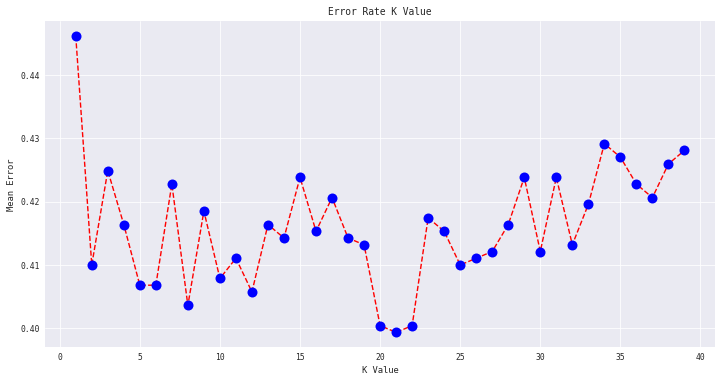

In [59]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  

In [60]:
model_knn = KNeighborsClassifier(n_neighbors=error.index(min(error))+1)  
model_knn.fit(x_train, y_train)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=21, p=2,
           weights='uniform')

In [61]:
pred_model_knn = model_knn.predict(x_test)

In [62]:
model_knn.score(x_test, y_test)

0.60063897763578278

### 2.2.3) SVM

In [86]:
model_svm = svm.SVC(gamma=0.3, decision_function_shape='ovo')
model_svm.fit(x_train, y_train)  
pred_model_svm = model_svm.predict(x_test)
model_svm.score(x_test, y_test)

0.5782747603833865

In [87]:
model_svm = svm.SVC(C= 3,gamma=  0.1, decision_function_shape='ovo')
model_svm.fit(x_train, y_train)  
pred_model_svm = model_svm.predict(x_test)
model_svm.score(x_test, y_test)

0.577209797657082

### 2.2.4) Random Forest

#### Sans PCA

In [144]:
model_rfc=RandomForestClassifier(bootstrap= True,
 max_depth= 10,
 max_features= 'sqrt',
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 1000)
model_rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [145]:
pred_model_rfc = model_rfc.predict(x_test)

In [146]:
model_rfc.score(x_test, y_test)

0.77103301384451539

#### Avec PCA

In [88]:
pca = PCA(n_components=40)
pca.fit(x_train)
x_train_transformed = pca.transform(x_train)


print(pca.explained_variance_ratio_)  

print(pca.singular_values_)  

[9.97359080e-01 2.60247739e-03 3.16660244e-05 1.32681408e-06
 7.15403320e-07 3.62490987e-07 3.25733325e-07 2.75153206e-07
 1.94720520e-07 1.37037699e-07 1.22215971e-07 1.10803993e-07
 9.45098898e-08 7.66335973e-08 7.25508486e-08 6.37467694e-08
 5.07847798e-08 4.98737647e-08 4.59544421e-08 3.73818115e-08
 3.38721306e-08 2.97522516e-08 2.75219424e-08 2.49727557e-08
 2.37529900e-08 2.06880133e-08 2.00949235e-08 1.88089866e-08
 1.86750043e-08 1.82838680e-08 1.76609703e-08 1.75258240e-08
 1.74093763e-08 1.70762919e-08 1.66655801e-08 1.59326685e-08
 1.58910668e-08 1.53317544e-08 1.52623417e-08 1.48939998e-08]
[9.06718395e+04 4.63169695e+03 5.10908849e+02 1.04580735e+02
 7.67930875e+01 5.46632261e+01 5.18176543e+01 4.76248852e+01
 4.00638346e+01 3.36098584e+01 3.17402714e+01 3.02220806e+01
 2.79116353e+01 2.51336903e+01 2.44550132e+01 2.29232264e+01
 2.04603680e+01 2.02760209e+01 1.94630278e+01 1.75540295e+01
 1.67096715e+01 1.56605342e+01 1.50621231e+01 1.43476207e+01
 1.39928377e+01 1.30588

In [90]:
model_rfc=RandomForestClassifier(bootstrap= True,
 max_depth= 10,
 max_features= 'sqrt',
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 1000)
model_rfc.fit(x_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [92]:
x_test_transformed = pca.transform(x_test)
pred_model_rfc = model_rfc.predict(x_test_transformed)
model_rfc.score(x_test_transformed, y_test)

0.8072417465388712

In [116]:
pca = PCA(n_components=20)
pca.fit(x_train)
x_train_transformed = pca.transform(x_train)


In [117]:
model_rfc=RandomForestClassifier(bootstrap= True,
 max_depth= 10,
 max_features= 'sqrt',
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators= 1000)
model_rfc.fit(x_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [118]:
x_test_transformed = pca.transform(x_test)
pred_model_rfc = model_rfc.predict(x_test_transformed)
model_rfc.score(x_test_transformed, y_test)

0.8029818956336529